In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sqlalchemy import create_engine
from psycopg2.extensions import register_adapter, AsIs
register_adapter(np.float32, AsIs)
register_adapter(np.int32, AsIs)
register_adapter(np.int64, AsIs)

from bornrule.bornrule import BornClassifier
from bornrule.bornrule.sql import BornClassifierSQL

In [ ]:
# MODIFY THE URL STRING
engine = create_engine(url="postgresql://<username>:<password>@<host>:<port>/<scopus_db>")

### Model Fitting 
The code assumes you have created a `train_table` inside database holding a subset of scopus publication ids from `scopus.publications.id` field

In [3]:
# set up configuratons for BornSQL
configs = {
    'class': ('publications.publication', 'id', 'subject_area'),
    'features': [
        ('publications.pub_author', 'pubid', 'authid'),
        ('publications.publication', 'id', 'pubname'),
        ('publications.keyword', 'pubid', 'keyword'),
        f"""SELECT * FROM (
            SELECT
               id AS item, 
              'publications.publication:title:'||lexeme AS feature,
               array_length(weights, 1)::float AS weight
            FROM publications.publication, LATERAL unnest(to_tsvector('english', publications.publication.title))) F  """
    ]
}

Create an instance of BornClassifierSQL passing the connection to the database and model configurations.\
Fit the instance on a subset of scopus publications stored in the `train_table`.

In [5]:
bc = BornClassifierSQL(engine=engine, configs=configs)
bc.fit("SELECT DISTINCT item FROM train_table", y=None)

Model Evaluation

In [10]:
with engine.connect() as con:
    y_true = pd.read_sql_query("SELECT DISTINCT item, subject FROM test_table", con)

y_pred = bc.predict("SELECT DISTINCT item AS id FROM test_table")
y_pred = pd.DataFrame(y_pred).reset_index()
y_pred.columns =["item", "prediction"]
result = y_true.merge(y_pred, on="item")
print("BornSQL Test Accuracy: ", sum(result["subject"].astype(np.int64) == result["prediction"]) / len(result))

0.7078571428571429

Run experiments against scikitlearn algorithms re-implemented in SQL.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

import scikit_learn_models # LogisticRegressionSQL, MultinomialNBSQL, DecisionTreeSQ
from utils import timing_sql, plot_timing

In [14]:
# BornClassifierSQL configuration file:
# sample_table is a training table used in the experiments and sampled at runtime from scopus for different sample sizes

born_configs = {
    'class': ('sample_table', 'item', 'subject'),
    'features': [
        ('publications.pub_author', 'pubid', 'authid'),
        ('publications.publication', 'id', 'pubname'),
        ('publications.keyword', 'pubid', 'keyword'),
    ]
}

models = {
    'BC': (BornClassifierSQL(engine=engine, configs=born_configs), BornClassifier()),
    'LR': (model.LogisticRegressionSQL(engine), LogisticRegression()),
    'MNB': (model.MultinomialNBSQL(engine), MultinomialNB()),
    'DT': (model.DecisionTreeSQL(engine), DecisionTreeClassifier())
}

In [10]:
#timing_sql(engine, models, runs=3)

Image saved in ./results.png


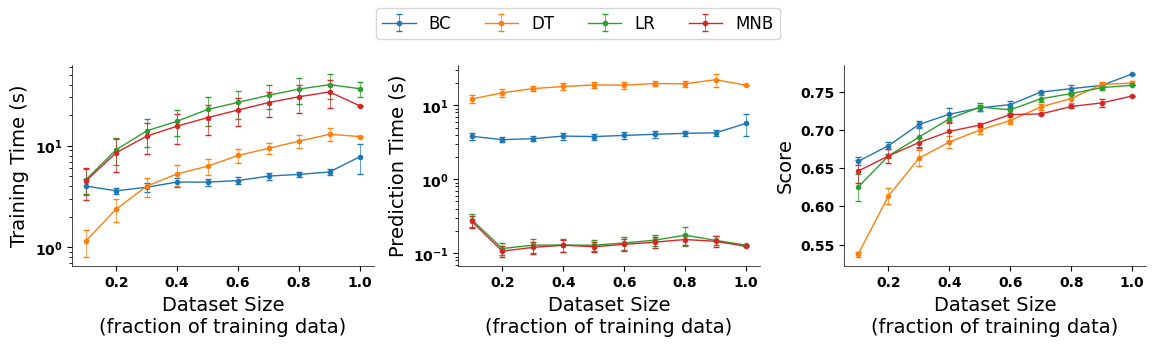

In [11]:
plot_timing()